<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. <br>
Значение метрики **RMSE** на **тестовой** выборке должно быть **не больше 48**.


**Описание данных:**<br>
Данные лежат в файле /datasets/taxi.csv. <br>
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Подготовка

In [1]:
!pip3 install catboost

In [2]:
# Установим последнюю версию scikit-learn чтобы в OHE одновременно работали drop='first' и handle_unknown='ignore'
!pip install scikit-learn==1.1.3

**Импортируем** необходимые для анализа **библиотеки**. <br>
**Прочитаем csv-файл** с данными из архива и сохраним в соответствующую переменную. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, GridSearchCV)
from sklearn.metrics import mean_squared_error 

from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler)
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


In [4]:
try:
    archive = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    archive = pd.read_csv('/Users/Julli/Desktop/JUL/DS/Спринт 10 Временные ряды/taxi.csv',index_col=[0], parse_dates=[0])

Выполним ресемплирование по одному часу.

In [5]:
archive.sort_index(inplace=True)
archive = archive.resample('1H').sum()
archive.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
def total_info(data):
    print('__________________________')
    print('Общая информация')
    print(data.info());
    print('__________________________')
    print('Количество пропусков')
    print(data.isna().sum());
    print('__________________________')
    print('Распределение значений  данных')
    print(data.describe());

In [7]:
total_info(archive)

__________________________
Общая информация
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
__________________________
Количество пропусков
num_orders    0
dtype: int64
__________________________
Распределение значений  данных
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


**Вывод:**<br>
1. Датасет состоит из 4416 строк. <br>
2. Есть только 1 столбец с количеством заказов ('num_orders'). <br>
3. Пропуски отстутсвуют. <br>
4. Сделали ресемплирование по одному часу.<br>
5. Пропуски отстутствуют.<br>
6. Информация представлена с 1 марта 2018 (00:00:00) по 31 августа 2018(23:00:00)

## Анализ

Построим график чтобы увидеть все наглядно.

In [8]:
FIGSIZE=(20, 10)

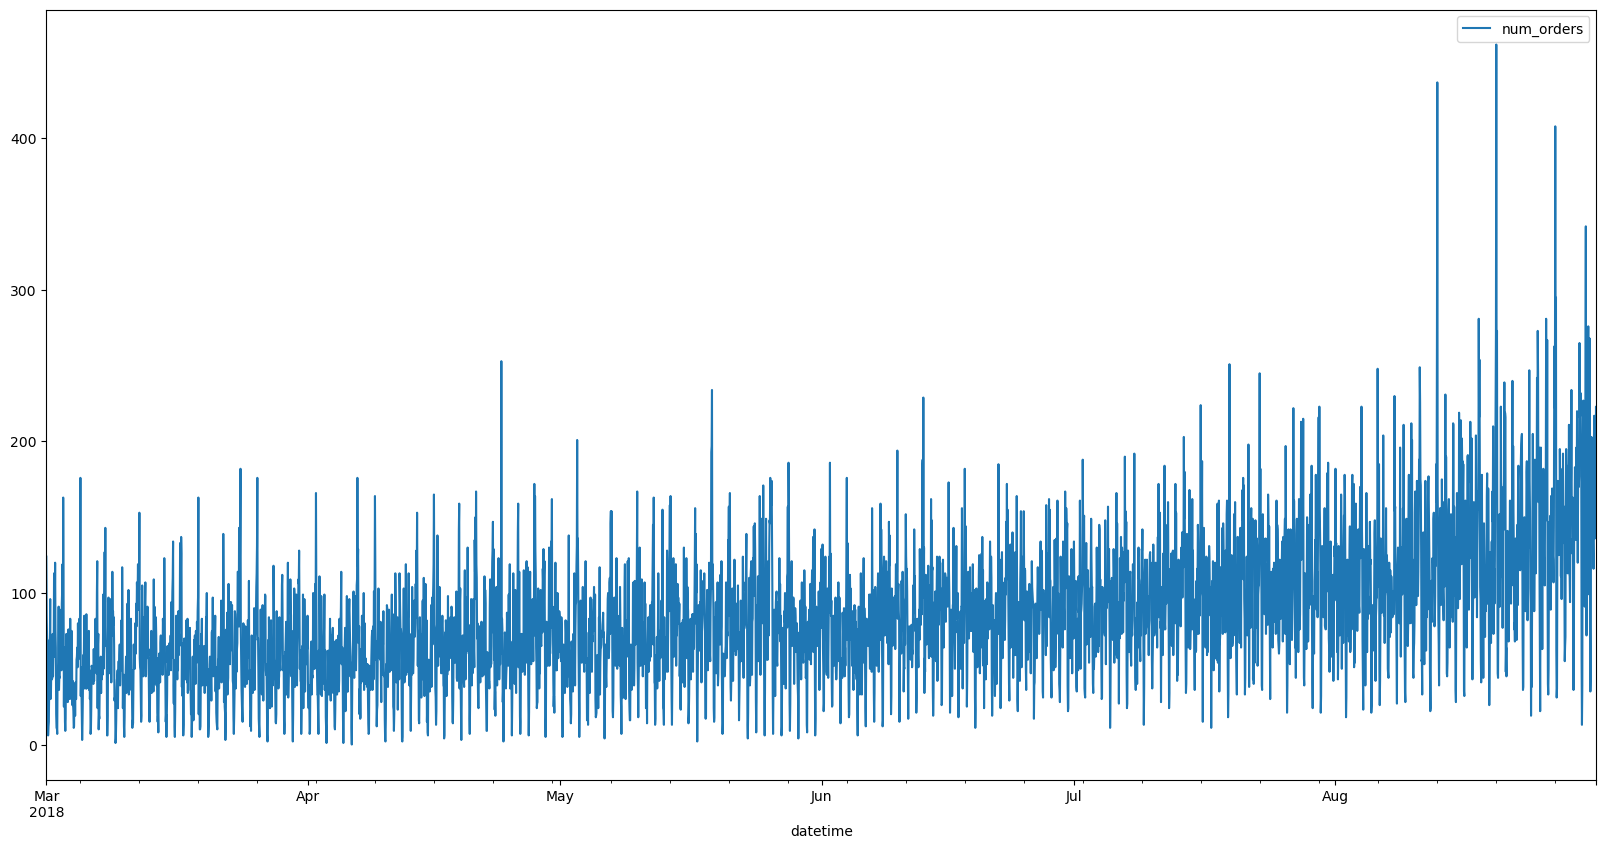

In [9]:
plt.figure(figsize=FIGSIZE)
archive.plot(ax=plt.gca());

График выглядит очень `шумным`, однако даже так мы можем сказать, что количество заказов в конце августа возросло.<br>
Найдем скользящее среднее, размер окна выберем сутки (24ч)

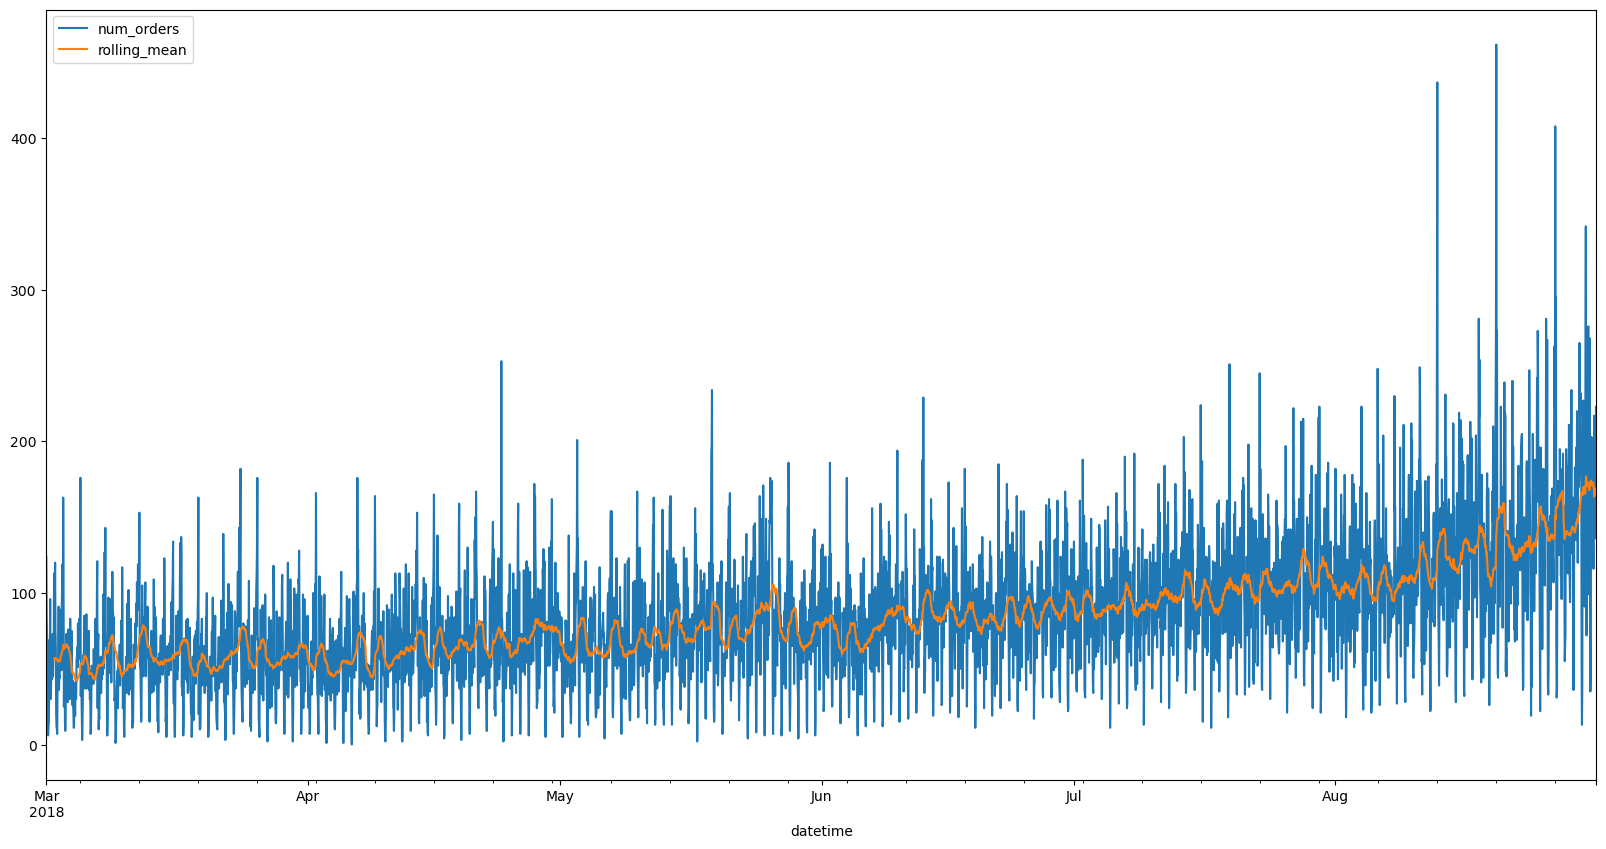

In [10]:
archive_copy = archive.copy()
archive_copy['rolling_mean'] = archive_copy['num_orders'].rolling(24).mean() 
plt.figure(figsize=FIGSIZE)
archive_copy.plot(ax=plt.gca());

На графике появилась оранжевая линия скользащего среднего.<br>
Теперь рассмотрим тренды и сезонность.

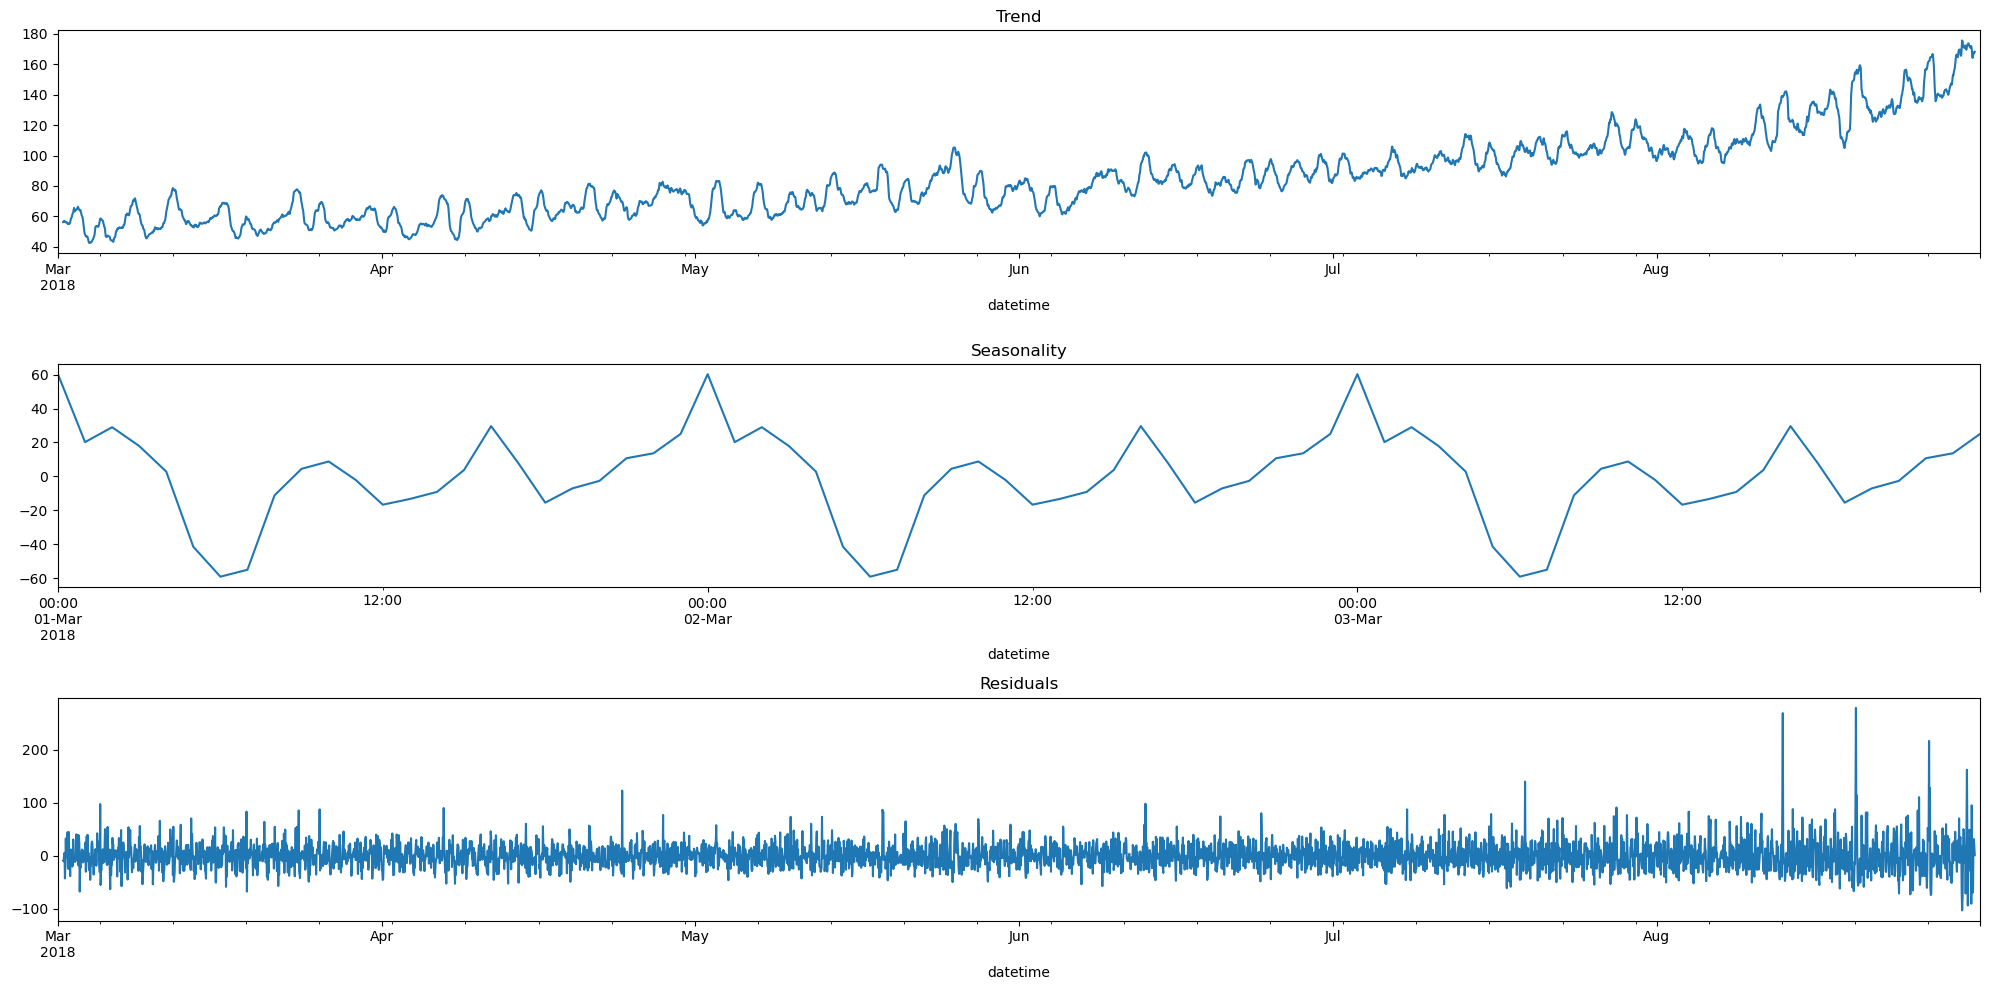

In [11]:
decomposed = seasonal_decompose(archive_copy['num_orders'])
plt.figure(figsize=FIGSIZE)
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.loc['2018-03-01':'2018-03-03'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

1. **Тренд**. Заметны колебания, но даже на их фоне видно, что кол-во заказов растет. Это может объясняться тем, что все возвращаются к 1 сентября из отпусков. <br>
2. **Сезонность** сложно вычислить на тех данных что есть, поэтому, выделив 3=дневный интервал, можно сделать вывод: спады всегда окло 6 утра, а пики заказов приходятся на полночь.<br>
3. Шум так же присутсвует в **остатке**. <br>
Так же делаем вывод, что **распределение** во временных рядах **меняется**, поэтому мы имеем дело с **нестационарным процессом**. Прогнозировать его сложнее, т.к. свойства меняются слишком быстро.

Чтобы ряд сделать стационарным, найдём разности его значений.

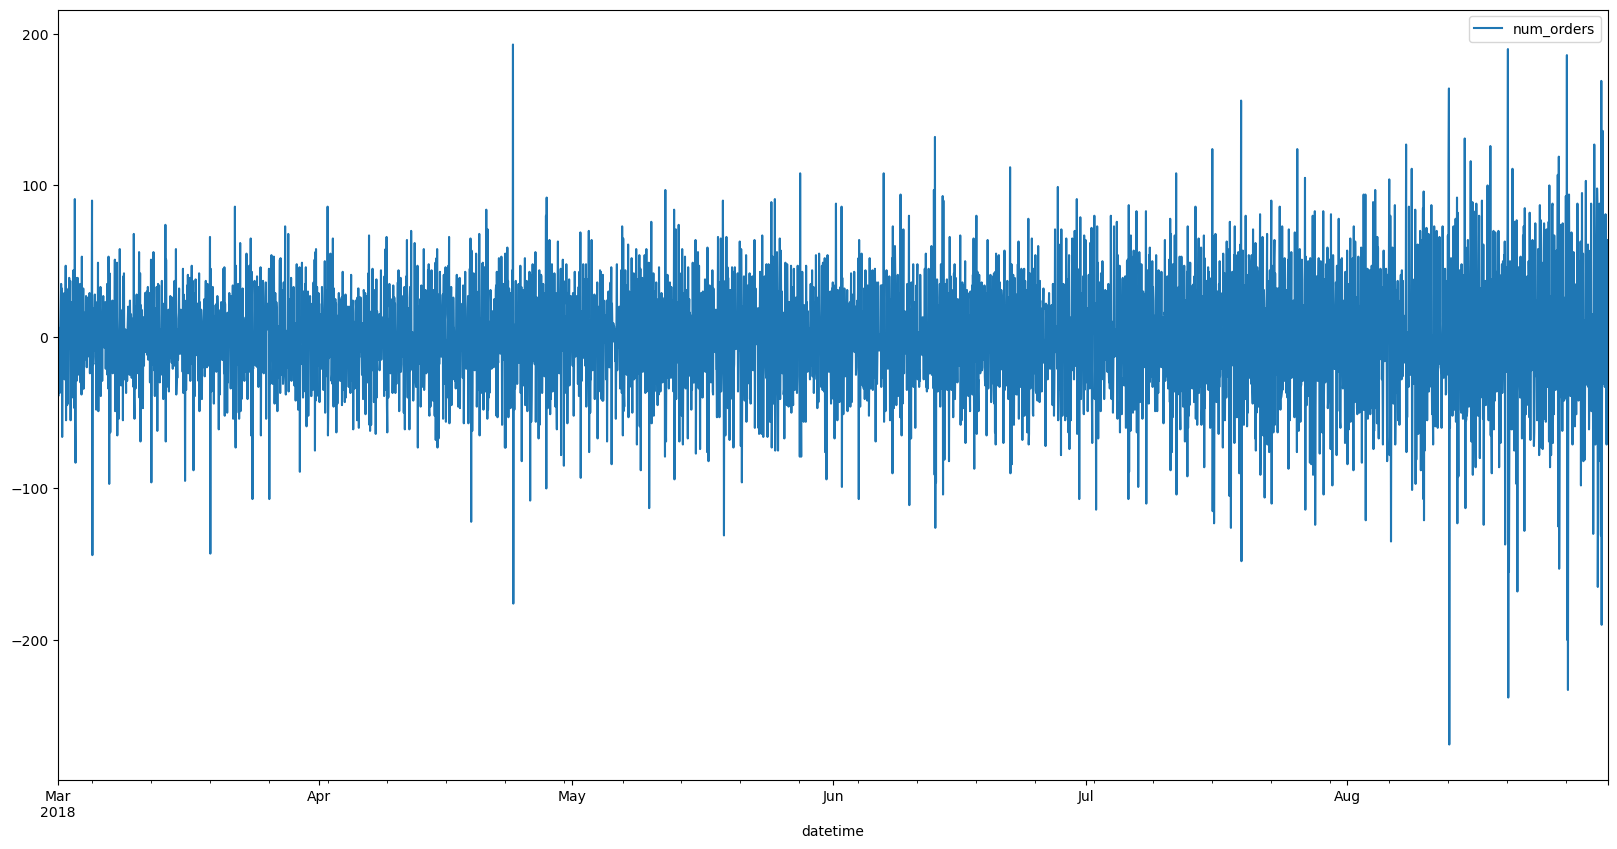

In [12]:
archive -= archive.shift(fill_value=0)
plt.figure(figsize=FIGSIZE)
archive.plot(ax=plt.gca());

**Вывод:**
1. К концу лета кол-во заказов растет, вероятнее всего из-за завершения отпусков перед сентябрем.
2. Несколько пиков на заказы можно наблюдать в течении дня. Самые большие показатели в полность, самые маленькие - раннее утро.
3. Временной ряд нестационарный, поэтому вычислили разности временного ряда.
Можно переходить к обучению моделей.

## Обучение

Для начала необходимо создать функцию для добавления новых признаков.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    
    
    data.loc[(data.index.hour >= 0) & (data.index.hour < 6), 'time_interval'] = 'morning'
    data.loc[(data.index.hour >= 6) & (data.index.hour < 12), 'time_interval'] = 'day'
    data.loc[(data.index.hour >= 12) & (data.index.hour < 18), 'time_interval'] = 'evening'
    data.loc[(data.index.hour >= 18) & (data.index.hour < 24), 'time_interval'] = 'night'
    data['time_interval'] = data['time_interval'].astype('category')
    
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek.astype('category')

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(archive, 24, 24)
archive.dropna(inplace=True)
archive.head(10)

,num_orders,time_interval,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,32,morning,2,4,-55.0,47.0,5.0,16.0,-28.0,29.0,...,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,124.0,2.416667
2018-03-02 01:00:00,30,morning,2,4,32.0,-55.0,47.0,5.0,16.0,-28.0,...,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,-1.416667
2018-03-02 02:00:00,-45,morning,2,4,30.0,32.0,-55.0,47.0,5.0,16.0,...,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,1.458333
2018-03-02 03:00:00,-11,morning,2,4,-45.0,30.0,32.0,-55.0,47.0,5.0,...,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,0.166667
2018-03-02 04:00:00,-44,morning,2,4,-11.0,-45.0,30.0,32.0,-55.0,47.0,...,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-0.083333
2018-03-02 05:00:00,-9,morning,2,4,-44.0,-11.0,-45.0,30.0,32.0,-55.0,...,2.0,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-0.958333
2018-03-02 06:00:00,0,day,2,4,-9.0,-44.0,-11.0,-45.0,30.0,32.0,...,16.0,2.0,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,0.208333
2018-03-02 07:00:00,-4,day,2,4,0.0,-9.0,-44.0,-11.0,-45.0,30.0,...,18.0,16.0,2.0,-66.0,32.0,-5.0,35.0,19.0,3.0,-0.041667
2018-03-02 08:00:00,39,day,2,4,-4.0,0.0,-9.0,-44.0,-11.0,-45.0,...,-23.0,18.0,16.0,2.0,-66.0,32.0,-5.0,35.0,19.0,-0.333333


In [15]:
features = archive.drop(['num_orders'], axis=1)
target = archive['num_orders']

Чтобы избежать утечки, сначала разделим данные на выборки. <br>
Данные нужно разбить на `обучающую` и `тестовую`. `Размеры` тестового набора должен быть **10%**.<br>
Применив `shuffle=False` мы знаем, что данные не перемешались.<br>

In [16]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.1, shuffle=False) 

print('Обучающая выборка', target_train.shape)
print('Тестовая выборка', target_test.shape)

Обучающая выборка (3952,)
Тестовая выборка (440,)


Так как данные являются временным рядом, нельзя применять кросс-валидацию в стандартном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit и запишем в новую переменную.

**1. Модель линейной регресии.** <br>
Создадим трансформер для линейной регрессии, где к категориальным признакам применим OHE, к числовым - StandardScaler.

In [17]:
lr_transformer = make_column_transformer(
    (OneHotEncoder(dtype='int8', handle_unknown='ignore'), make_column_selector(dtype_include=['category'])),
    (StandardScaler(), make_column_selector(dtype_include='number')),
    remainder='passthrough')

In [18]:
lr_pipe = make_pipeline(lr_transformer,LinearRegression(n_jobs=-1))

In [19]:
tss = TimeSeriesSplit(n_splits=3,gap=(24 * 7))

In [20]:
param_grid = {'linearregression__normalize':[False, True]}
lr_gs = GridSearchCV(lr_pipe, param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tss, verbose=1)
lr_gs.fit(features_train, target_train);

Fitting 3 folds for each of 2 candidates, totalling 6 fits


d:\Proggrams\anaconda\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [42]:
table = pd.DataFrame(lr_gs.cv_results_)
table['mean_test_score'] = (-table['mean_test_score'])

results = {} 
results['Linear Regression'] = float(table[table['rank_test_score'] == 1]['mean_test_score'].values[0])

table[['param_linearregression__normalize', 'mean_fit_time', 'mean_score_time','mean_test_score', 'rank_test_score']]

,param_linearregression__normalize,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,False,0.056411,0.008903,27.538893,1
1,True,0.033350,0.009274,27.550942,2


**2. Модель Модель случайного леса** <br>
Создадим трансформер, где к категориальным признакам применим OE, числовые не изменяем.



In [22]:
rf_transformer = make_column_transformer(
    (OrdinalEncoder(dtype='int8', handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=['category'])),
    remainder='passthrough')

In [23]:
rf_pipe = make_pipeline(rf_transformer, RandomForestRegressor(n_jobs=-1,verbose=0))

In [24]:
param_grid = {'randomforestregressor__max_depth':[d for d in range(1,20,4)]}
fr_gr = GridSearchCV(rf_pipe, param_grid, cv=tss, n_jobs = -1,scoring='neg_root_mean_squared_error',verbose=1)
fr_gr.fit(features_train, target_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [43]:
table = pd.DataFrame(fr_gr.cv_results_)
table['mean_test_score'] = (-table['mean_test_score'])

results['Random Forest Regressor'] = float(table[table['rank_test_score'] == 1]['mean_test_score'].values[0])

table[['params', 'mean_fit_time', 'mean_score_time','mean_test_score', 'rank_test_score']]

,params,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,{'randomforestregressor__max_depth': 1},0.407738,0.285339,35.601976,5
1,{'randomforestregressor__max_depth': 5},1.236193,0.545350,29.427367,4
2,{'randomforestregressor__max_depth': 9},2.176349,0.755311,28.906386,3
3,{'randomforestregressor__max_depth': 13},2.990821,0.799209,28.764311,1
4,{'randomforestregressor__max_depth': 17},2.809731,0.399217,28.810311,2


**3. Модель Cat Boost** <br>
Нет необходимости использовать OHE, просто укажем какие признаки являются категоривальными `cat_features`

In [26]:
%%time

model = CatBoostRegressor(loss_function=’RMSE’)
param_grid = {'max_depth' : [d for d in range(1,20,2)],
              'iterations' : [500],
              'random_state' : [12345]}

grid_CBR = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=tss)

cat_features = ['time_interval','day_of_week']
grid_CBR.fit(features_train, target_train, cat_features=cat_features);

In [44]:
table = pd.DataFrame(grid_CBR.cv_results_)
table['mean_test_score'] = np.sqrt(-table['mean_test_score'])

results['Cat Boost Regressor'] = float(table[table['rank_test_score'] == 1]['mean_test_score'].values[0])

table[['param_iterations', 'param_max_depth', 'param_random_state','mean_fit_time', 'mean_score_time','mean_test_score', 'rank_test_score']]

,param_iterations,param_max_depth,param_random_state,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,500,1,12345,4.258425,0.016520,29.022786,9
1,500,2,12345,7.862881,0.024101,28.450496,7
2,500,3,12345,10.947468,0.008976,28.185426,5
3,500,4,12345,14.476169,0.020612,28.026089,3
4,500,5,12345,24.159093,0.089760,27.850984,1
5,500,6,12345,28.511651,0.028591,28.033526,4
6,500,7,12345,33.095329,0.014960,28.007194,2
7,500,8,12345,47.413739,0.032913,28.361803,6
8,500,9,12345,64.725779,0.011636,28.711615,8


In [45]:
pd.DataFrame(results,index=['Model RMSE'])

,Linear Regression,Random Forest Regressor,Cat Boost Regressor
Model RMSE,27.538893,28.764311,27.850984


**Вывод:**
1. Все три модели показали хороший RMSE, ниже планки установленной в начале проекта (48).
2. Показатели модели линейной регрессии и Catboost примерно равны, но линейная модель обучается и предсказывает намного быстрее. Значит выберем эту модель для прогнозирования на тестовой выборке.

## Тестирование

In [41]:
%%time

pred = lr_gs.predict(features_test)
rmse = mean_squared_error(target_test, pred)**0.5

print('RMSE на тестовой выборке', round(rmse,2))

RMSE на тестовой выборке 44.29
Wall time: 13 ms


## **Общий вывод:**
1. Мы загрузили и изучили данные.
2. Подготовили данные к дальнейшей работе(пропуски отстутсвуют, данные ресеплированы по 1 часу).
3. Проанализировали данные. Выявили тренд, сезонность и шумы. Определили скользяжее среднее при размере окна в 24 часа.
4. Обучили модели с различными гиперпараметрами и выбрали лучшую, при условии lag и rolling_mean равные 24.
5. Значение метрики RMSE на тестовой выборке 44.29 (**не превысило 48**, как и сказано в условии).

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.
- [ ]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48